<a href="https://colab.research.google.com/github/jhubar/master-thesis/blob/main/small/LMV2_LARGE_bbt_star.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Install dependencies

In [1]:
!rm -r transformers
!git clone https://github.com/huggingface/transformers.git
!cd tranformers
!pip install -q ./transformers 

Cloning into 'transformers'...
remote: Enumerating objects: 96648, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 96648 (delta 72), reused 123 (delta 58), pack-reused 96488
Receiving objects: 100% (96648/96648), 89.31 MiB | 28.30 MiB/s, done.
Resolving deltas: 100% (71043/71043), done.
/bin/bash: line 0: cd: tranformers: No such file or directory
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
!pip install -q datasets seqeval

In [3]:
!pip install pyyaml==5.1
# workaround: install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install detectron2 that matches pytorch 1.8
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [4]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
path_btt_large_qv = '/content/drive/MyDrive/LayoutLMv2/final/btt_large_star'
folder = '/content/drive/MyDrive/lr_1e5/LMV2/bttStar/'

In [7]:
train = pd.read_pickle(path_btt_large_qv+'/pickel/train.pkl')
val = pd.read_pickle(path_btt_large_qv+'/pickel/dev.pkl')
test = pd.read_pickle(path_btt_large_qv+'/pickel/test.pkl')

## Prepare the data



In [8]:
from collections import Counter

all_labels = [item for sublist in train[1] for item in sublist] + [item for sublist in val[1] for item in sublist] + [item for sublist in test[1] for item in sublist]
Counter(all_labels)

Counter({'Base': 9690,
         'DueDate': 17089,
         'Duedate': 6,
         'Rem': 6104,
         'RemPay': 3034,
         'TotAmount': 9253,
         'VatNr': 19098,
         'iban': 42302,
         'noise': 1587894,
         'tax': 9233})

Let's replace label noise by the "neutral" label "O" (which stands for "Outside").

In [9]:
replacing_labels = {'noise': 'O','dueDate':'O'}

In [10]:
def replace_elem(elem):
  try:
    return replacing_labels[elem]
  except KeyError:
    return elem
def replace_list(ls):
  return [replace_elem(elem) for elem in ls]


train[1] = [replace_list(ls) for ls in train[1]]
val[1] = [replace_list(ls) for ls in val[1]]
test[1] = [replace_list(ls) for ls in test[1]]


In [11]:
all_labels = [item for sublist in train[1] for item in sublist] + [item for sublist in val[1] for item in sublist] + [item for sublist in test[1] for item in sublist]
Counter(all_labels)
labels = list(set(all_labels))
print(labels)
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for idx, label in enumerate(labels)}
print(label2id)
print(id2label)


['VatNr', 'RemPay', 'Rem', 'TotAmount', 'iban', 'tax', 'Base', 'DueDate', 'Duedate', 'O']
{'VatNr': 0, 'RemPay': 1, 'Rem': 2, 'TotAmount': 3, 'iban': 4, 'tax': 5, 'Base': 6, 'DueDate': 7, 'Duedate': 8, 'O': 9}
{0: 'VatNr', 1: 'RemPay', 2: 'Rem', 3: 'TotAmount', 4: 'iban', 5: 'tax', 6: 'Base', 7: 'DueDate', 8: 'Duedate', 9: 'O'}


Now we have to save all the unique labels in a list.

In [12]:
from os import listdir
from torch.utils.data import Dataset
import torch
from PIL import Image
class BILLYDataset(Dataset):
    """BillyDataset dataset."""

    def __init__(self, annotations, image_dir, processor=None, max_length=512):
        """
        Args:
            annotations (List[List]): List of lists containing the word-level annotations (words, labels, boxes).
            image_dir (string): Directory with all the document images.
            processor (LayoutLMv2Processor): Processor to prepare the text + image.
        """
        self.words, self.labels, self.boxes = annotations
        self.image_dir = image_dir
        self.image_file_names = [f for f in listdir(image_dir)]
        self.processor = processor
        self.max_length = max_length
        

    def __len__(self):
        return len(self.image_file_names)

    def __getitem__(self, idx):
        item = self.image_file_names[idx]
        image = Image.open(self.image_dir + item).convert("RGB")
        words = self.words[idx]
        boxes = self.boxes[idx]
        word_labels = self.labels[idx]

        
        assert len(words) == len(boxes) == len(word_labels)
       
        word_labels = [label2id[label] for label in word_labels]
       
        # use processor to prepare everything
        encoded_inputs = processor(image, words, boxes=boxes, word_labels=word_labels,
                              padding="max_length", truncation=True, max_length=512, return_token_type_ids=True,return_tensors="pt")
        
        # remove batch dimension
        for k,v in encoded_inputs.items():
          encoded_inputs[k] = v.squeeze()

        assert encoded_inputs.input_ids.shape == torch.Size([512])
        assert encoded_inputs.attention_mask.shape == torch.Size([512])
        assert encoded_inputs.token_type_ids.shape == torch.Size([512])
        assert encoded_inputs.bbox.shape == torch.Size([512, 4])
        assert encoded_inputs.image.shape == torch.Size([3, 224, 224])
        assert encoded_inputs.labels.shape == torch.Size([512]) 
      
        return encoded_inputs
    


In [13]:
# from transformers import LayoutLMv2FeatureExtractor
# from transformers import LayoutXLMTokenizer
# from transformers import LayoutXLMProcessor
# from transformers import LayoutLMv2Processor


# # feature_extractor = LayoutLMv2FeatureExtractor(apply_ocr=False)
# # tokenizer = LayoutXLMTokenizer.from_pretrained("microsoft/layoutxlm-base")
# # processor = LayoutXLMProcessor(feature_extractor,tokenizer)
# processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-large-uncased", apply_ocr=False)

from transformers import LayoutLMv2Processor,AutoTokenizer 


from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2TokenizerFast, LayoutLMv2Processor

feature_extractor = LayoutLMv2FeatureExtractor(apply_ocr=False)  # apply_ocr is set to True by default
tokenizer = AutoTokenizer.from_pretrained("microsoft/layoutlmv2-large-uncased")
processor = LayoutLMv2Processor(feature_extractor, tokenizer)

train_dataset = BILLYDataset(annotations=train,
                            image_dir= path_btt_large_qv+'/train/image/', 
                            processor=processor)
print(len(train_dataset))
val_dataset = BILLYDataset(annotations=val,
                            image_dir=path_btt_large_qv+'/dev/image/', 
                            processor=processor)
print(len(val_dataset))
test_dataset = BILLYDataset(annotations=test,
                            image_dir=path_btt_large_qv+'/test/image/', 
                            processor=processor)
print(len(test_dataset))




8252
980
1031


In [14]:
from torch.utils.data import DataLoader
small_train_dataset = torch.utils.data.Subset(train_dataset, list(range(746)))
small_val_dataset = torch.utils.data.Subset(val_dataset, list(range(94)))
small_test_dataset = torch.utils.data.Subset(test_dataset, list(range(94)))
batch_size = 2
train_dataloader = DataLoader(small_train_dataset, batch_size=batch_size,shuffle=True)
print(len(train_dataloader))
val_dataloader = DataLoader(small_val_dataset, batch_size=batch_size, shuffle=True)
print(len(val_dataloader))
test_dataloader = DataLoader(small_test_dataset, batch_size=batch_size)
print(len(test_dataloader))
print(len(test_dataloader)+len(test_dataloader)+len(train_dataloader))


373
47
47
467


In [15]:
print(len(test_dataset)+len(val_dataset)+len(train_dataset))

10263


Next, we create corresponding dataloaders.

In [16]:
# from torch.utils.data import DataLoader
# batch_size = 2
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# print(len(train_dataloader))
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
# print(len(val_dataloader))
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
# print(len(test_dataloader))
# print(len(test_dataloader)+len(test_dataloader)+len(train_dataloader))

## Train the model

train the model
learning rate = 1e-5 



In [17]:
import warnings
warnings.filterwarnings("ignore")
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)

def results_test(preds, out_label_ids, labels):
  preds = np.argmax(preds, axis=2)

  label_map = {i: label for i, label in enumerate(labels)}

  out_label_list = [[] for _ in range(out_label_ids.shape[0])]
  preds_list = [[] for _ in range(out_label_ids.shape[0])]

  for i in range(out_label_ids.shape[0]):
      for j in range(out_label_ids.shape[1]):
          if out_label_ids[i, j] != -100:
              out_label_list[i].append(label_map[out_label_ids[i][j]])
              preds_list[i].append(label_map[preds[i][j]])

  
  results = {
      "precision": precision_score(out_label_list, preds_list),
      "recall": recall_score(out_label_list, preds_list),
      "f1": f1_score(out_label_list, preds_list),
  }
 
  return results,out_label_list, preds_list

In [18]:
from transformers import LayoutLMv2ForTokenClassification, AdamW
import torch
from tqdm.notebook import tqdm
from numpy import asarray
from numpy import savetxt
import numpy as np
import json
import itertools
print(torch.cuda.get_device_name(0))
model = LayoutLMv2ForTokenClassification.from_pretrained("microsoft/layoutlmv2-large-uncased",
                                                                      num_labels=len(labels))
labels = list(set(all_labels))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cuda'
print(device)
model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)


Tesla V100-SXM2-16GB


Some weights of the model checkpoint at microsoft/layoutlmv2-large-uncased were not used when initializing LayoutLMv2ForTokenClassification: ['layoutlmv2.visual.backbone.bottom_up.res4.3.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.0.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.17.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.1.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.1.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.9.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.0.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.2.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.2.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.19.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.3.conv1.norm.num_batches_tracked'

cuda:0


In [19]:


val_iterator = iter(val_dataloader)
global_step = 0
num_train_epochs = 4
train_loss = []
val_loss = []
val_precision = []
val_recall = []
val_f1 = []
preds_val = None
out_label_ids = None
batch_logits_array = []
out_label_list=[]
preds_list=[]
#put the model in training mode
val_batch_idx = 0
for epoch in range(num_train_epochs):  
   print("Epoch:", epoch)
   loop = tqdm(train_dataloader, leave=True)
   for batch_id, batch in enumerate(loop):
        model.train() 
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(input_ids=input_ids,
                        bbox=bbox,
                        image=image,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        labels=labels) 
        loss = outputs.loss
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
        # Testing part
        if val_batch_idx >= len(val_iterator):
            val_iterator = iter(val_dataloader)
            val_batch_idx = 0
        val_batch_idx += 1
        model.eval()
        with torch.no_grad():
            batch = next(val_iterator)
            input_ids = batch['input_ids'].to(device)
            bbox = batch['bbox'].to(device)
            image = batch['image'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)
            # forward pass
            outputs = model(input_ids=input_ids, bbox=bbox, image=image, attention_mask=attention_mask, 
                            token_type_ids=token_type_ids, labels=labels)
            if preds_val is None:
                preds_val = outputs.logits.detach().cpu().numpy()
                out_label_ids = batch["labels"].detach().cpu().numpy()
            else:
                preds_val = np.append(preds_val, outputs.logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(out_label_ids, batch["labels"].detach().cpu().numpy(), axis=0)
       

        
        loss = outputs.loss
        val_loss.append(loss.item())
         
        if global_step % 100 == 0 or global_step == 0:
            val_result,out_label_l,preds_l = results_test(preds_val, out_label_ids, list(set(all_labels)))
            val_precision.append(val_result['precision'])
            val_recall.append(val_result['recall'])
            val_f1.append(val_result['f1'])
            out_label_list.append(list(itertools.chain(*out_label_l)))
            preds_list.append(list(itertools.chain(*preds_l)))

        
            
            print("Overall results:", val_result)
            print(f"Loss after {global_step} steps: {train_loss[-1]}")
            print("Validation loss: {}".format(loss.item()))
        global_step += 1


model.save_pretrained("/content/drive/MyDrive/smallLayoutLMV2/check_points/LargeCheckpoints_xlm_lr_1e5")
path_model = "/content/drive/MyDrive/smallLayoutLMV2/large_model_xlm_btt_qv_lr_star_1e5.pt"
torch.save(model, path_model)




Epoch: 0


  0%|          | 0/373 [00:00<?, ?it/s]

Overall results: {'precision': 0.011235955056179775, 'recall': 0.08333333333333333, 'f1': 0.019801980198019802}
Loss after 0 steps: 2.3699183464050293
Validation loss: 1.7448610067367554
Overall results: {'precision': 0.4912689173457509, 'recall': 0.2959326788218794, 'f1': 0.36936542669584244}
Loss after 100 steps: 0.10541057586669922
Validation loss: 0.04989663138985634
Overall results: {'precision': 0.6693548387096774, 'recall': 0.5531392493861803, 'f1': 0.6057230651046668}
Loss after 200 steps: 0.08661611378192902
Validation loss: 0.03020986169576645
Overall results: {'precision': 0.736132711249352, 'recall': 0.6629318394024276, 'f1': 0.697617293048391}
Loss after 300 steps: 0.038112614303827286
Validation loss: 0.04287681728601456
Epoch: 1


  0%|          | 0/373 [00:00<?, ?it/s]

Overall results: {'precision': 0.7729000380083618, 'recall': 0.7163995067817509, 'f1': 0.7435780235853369}
Loss after 400 steps: 0.020763933658599854
Validation loss: 0.007295246236026287
Overall results: {'precision': 0.7984014209591475, 'recall': 0.7580101180438449, 'f1': 0.7776816608996541}
Loss after 500 steps: 0.04206528142094612
Validation loss: 0.008704237639904022
Overall results: {'precision': 0.8174126302881668, 'recall': 0.7827618600281823, 'f1': 0.7997120748605363}
Loss after 600 steps: 0.028061561286449432
Validation loss: 0.03798164054751396
Overall results: {'precision': 0.8301671338108585, 'recall': 0.8032342306147047, 'f1': 0.8164786359691664}
Loss after 700 steps: 0.014509635977447033
Validation loss: 0.0018894083332270384
Epoch: 2


  0%|          | 0/373 [00:00<?, ?it/s]

Overall results: {'precision': 0.8400795084929527, 'recall': 0.8184138720183083, 'f1': 0.8291051763342102}
Loss after 800 steps: 0.02037510648369789
Validation loss: 0.028092315420508385
Overall results: {'precision': 0.8480760019160147, 'recall': 0.8302461899179366, 'f1': 0.8390663875834287}
Loss after 900 steps: 0.037218913435935974
Validation loss: 0.0084203090518713
Overall results: {'precision': 0.8542069459362692, 'recall': 0.8400704225352112, 'f1': 0.8470797088585124}
Loss after 1000 steps: 0.01575993373990059
Validation loss: 0.036109864711761475
Overall results: {'precision': 0.859300064808814, 'recall': 0.848087501599079, 'f1': 0.8536569662631986}
Loss after 1100 steps: 0.001768183195963502
Validation loss: 0.004185103811323643
Epoch: 3


  0%|          | 0/373 [00:00<?, ?it/s]

Overall results: {'precision': 0.8628344778593418, 'recall': 0.8552399953057153, 'f1': 0.8590204514646077}
Loss after 1200 steps: 0.00037187442649155855
Validation loss: 0.02429717592895031
Overall results: {'precision': 0.867724002616089, 'recall': 0.8619457528016892, 'f1': 0.8648252261060866}
Loss after 1300 steps: 0.013381686992943287
Validation loss: 0.004155819769948721
Overall results: {'precision': 0.8714011516314779, 'recall': 0.8673705379587733, 'f1': 0.8693811731505745}
Loss after 1400 steps: 0.009468241594731808
Validation loss: 0.0007236478850245476


In [20]:
# define data
folder = "/content/drive/MyDrive/smallLayoutLMV2"
data_loss = pd.DataFrame({'batch_loss_array': train_loss,'val_loss':val_loss})
data_loss.to_csv(folder + '/output/logits_btt_qv_large_star_lr_1e5.csv')
data_loss = pd.DataFrame({'precison':val_precision,'recall':val_recall,'f1':val_f1})
data_loss.to_csv(folder + '/output/metrics.csv')
data_loss = pd.DataFrame({'preds_list':preds_list,'out_label_list':out_label_list})
data_loss.to_csv(folder + '/output/classification_reports.csv')


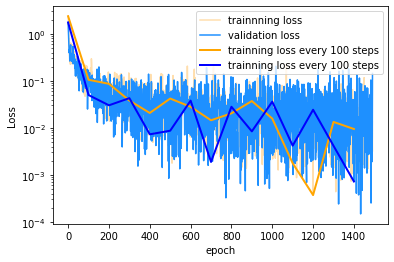

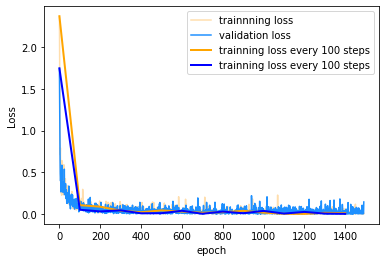

In [21]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 



x_avg_train_loss = []
y_avg_train_loss = []
x_avg_val_loss = []
y_avg_val_loss = []

x_val_precision = []
y_val_precision = []

x_avg_val_recall = []
y_avg_val_recall = []

x_avg_val_f1 = []
y_avg_val_f1 = []

for i in range(0,len(train_loss)):
   if i%100==0:
      x_avg_train_loss.append(i)
      y_avg_train_loss.append(train_loss[i]) 

for i in range(0,len(val_loss)):
   if i%100==0:
      x_avg_val_loss.append(i)
      y_avg_val_loss.append(val_loss[i]) 
      

for i in range(0,len(val_loss)):
  if i%100==0:
    try:
      x_val_precision.append(i)
      y_val_precision.append(val_precision[i])
      x_avg_val_recall.append(i)
      y_avg_val_recall.append(val_recall[i])
      x_avg_val_f1.append(i)
      y_avg_val_f1.append(val_f1[i])
    except:
      break
        

# # Loss 
plt.plot((train_loss), label = 'trainnning loss',color= 'navajowhite')
plt.plot((val_loss),label = 'validation loss',color='dodgerblue')
plt.plot(x_avg_train_loss,y_avg_train_loss,label='trainning loss every 100 steps',linewidth=2,color='orange')
plt.plot(x_avg_val_loss,y_avg_val_loss,label='trainning loss every 100 steps',linewidth=2,color='blue')



plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.savefig(folder+'btt_qv_lr__star_1e5_log_test.png')
plt.legend()
plt.show()
# Loss 
plt.plot((train_loss), label = 'trainnning loss',color= 'navajowhite')
plt.plot((val_loss),label = 'validation loss',color='dodgerblue')
plt.plot(x_avg_train_loss,y_avg_train_loss,label='trainning loss every 100 steps',linewidth=2,color='orange')
plt.plot(x_avg_val_loss,y_avg_val_loss,label='trainning loss every 100 steps',linewidth=2,color='blue')

plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(folder+'btt_qv_star_lr_1e5_test.png')
plt.show()



## Evaluation

Let's evaluate the model on the test set. First, let's do a sanity check on the first example of the test set.

In [22]:
import warnings
warnings.filterwarnings("ignore")
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)
import numpy as np

from transformers import LayoutLMv2ForTokenClassification, AdamW
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cuda'
print(device)
from tqdm.notebook import tqdm
from numpy import asarray
from numpy import savetxt
import numpy as np


preds_val = None
out_label_ids = None

# put model in evaluation mode
model.eval()
batch_test_array = []
for batch in tqdm(test_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, image=image, attention_mask=attention_mask, 
                        token_type_ids=token_type_ids, labels=labels)
      
        
        if preds_val is None:
          preds_val = outputs.logits.detach().cpu().numpy()
          out_label_ids = batch["labels"].detach().cpu().numpy()
        else:
          preds_val = np.append(preds_val, outputs.logits.detach().cpu().numpy(), axis=0)
          out_label_ids = np.append(
              out_label_ids, batch["labels"].detach().cpu().numpy(), axis=0
          )
        


cuda:0


Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

In [23]:
import warnings
warnings.filterwarnings("ignore")
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)

def results_test(preds, out_label_ids, labels):
  preds = np.argmax(preds, axis=2)

  label_map = {i: label for i, label in enumerate(labels)}

  out_label_list = [[] for _ in range(out_label_ids.shape[0])]
  preds_list = [[] for _ in range(out_label_ids.shape[0])]

  for i in range(out_label_ids.shape[0]):
      for j in range(out_label_ids.shape[1]):
          if out_label_ids[i, j] != -100:
              out_label_list[i].append(label_map[out_label_ids[i][j]])
              preds_list[i].append(label_map[preds[i][j]])

  
  results = {
      "precision": precision_score(out_label_list, preds_list),
      "recall": recall_score(out_label_list, preds_list),
      "f1": f1_score(out_label_list, preds_list),
  }
  return results, classification_report(out_label_list, preds_list)

In [24]:
labels = list(set(all_labels))
val_result, class_report = results_test(preds_val, out_label_ids, labels)
print("Overall results:", val_result)
print(class_report)

Overall results: {'precision': 0.9312865497076024, 'recall': 0.9451038575667656, 'f1': 0.9381443298969072}
              precision    recall  f1-score   support

         ase       0.92      0.93      0.93        90
        atNr       0.99      0.99      0.99       121
          ax       0.92      0.98      0.95        91
         ban       0.99      0.98      0.98        99
          em       0.71      0.80      0.75        51
       emPay       1.00      0.94      0.97        32
    otAmount       0.94      0.94      0.94        90
      ueDate       0.92      0.91      0.91       100

   micro avg       0.93      0.95      0.94       674
   macro avg       0.92      0.93      0.93       674
weighted avg       0.93      0.95      0.94       674



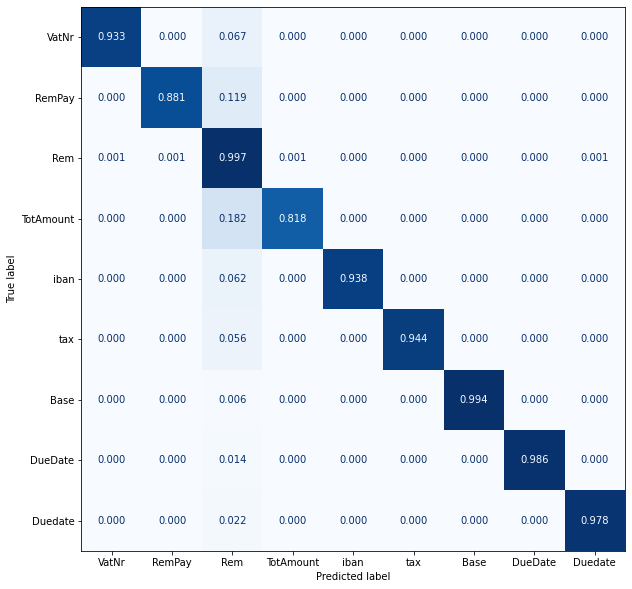

In [25]:
from matplotlib import figure
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import json
import itertools

def plot_confusion_matrix(y_preds,y_true,labels):
  cm = confusion_matrix(y_true,y_preds,normalize= "true")
  fig, ax = plt.subplots(figsize=(10,10))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
  disp.plot(cmap="Blues",values_format=".3f",ax=ax,colorbar=False)
  # plt.title("Normalized confusion matrix")
  plt.show()

def results_cm(preds, out_label_ids, labels):
  preds = np.argmax(preds, axis=2)

  label_map = {i: label for i, label in enumerate(labels)}

  out_label_list = [[] for _ in range(out_label_ids.shape[0])]
  preds_list = [[] for _ in range(out_label_ids.shape[0])]

  for i in range(out_label_ids.shape[0]):
      for j in range(out_label_ids.shape[1]):
          if out_label_ids[i, j] != -100:
              out_label_list[i].append(label_map[out_label_ids[i][j]])
              preds_list[i].append(label_map[preds[i][j]])


  return out_label_list,preds_list
def flatten(list_of_lists):
    if len(list_of_lists) == 0:
        return list_of_lists
    if isinstance(list_of_lists[0], list):
        return flatten(list_of_lists[0]) + flatten(list_of_lists[1:])
    return list_of_lists[:1] + flatten(list_of_lists[1:])

# plot_confusion_matrix(preds_val, out_label_ids, labels)
# preds_val
out_label_list,preds_list =results_cm(preds_val, out_label_ids, labels)

out_label_list = list(itertools.chain(*out_label_list))
preds_list = list(itertools.chain(*preds_list))

data_conf = {'out_label_list':out_label_list,'preds_list':preds_list,'labels':labels}

with open(folder+'/data_conf.json', 'w', encoding='utf-8') as f:
    json.dump(data_conf, f, ensure_ascii=False, indent=4)


plot_confusion_matrix(preds_list,out_label_list, labels)